In [1]:
import sys
import importlib
# Add a directory to the search path
sys.path.append('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/Seismic_AI')
from utils.utils import (
    preprocess_traces,
    find_max_trace_length,
    read_segy_file,
    visualize_seismic_data,
    train_contrastive_ts,
    segment_into_sequences,
    create_patches,
    scale_subsequences,
    reshape_into_subsequences,
    generate_test_pairs
)
from data.preprocess import TimeSeriesTFRecordReader,ImageMaskTFRecordWriter,TimeSeriesTFRecordWriter,TFRecordReader,TFRecordWriter
from models.contrastive_learning import ContrastiveTimeSeriesModel, TimeSeriesAugmentation, Contrastive1DCNNModel
from models.contrastive_learning import generate_pairs, contrastive_loss, augment_time_series

import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Print all directories Python will search for modules
# import sys
# for path in sys.path:
#     print(path)


In [2]:
print(tf.__version__)
# check to make sure 2.16 is installed


2.16.1


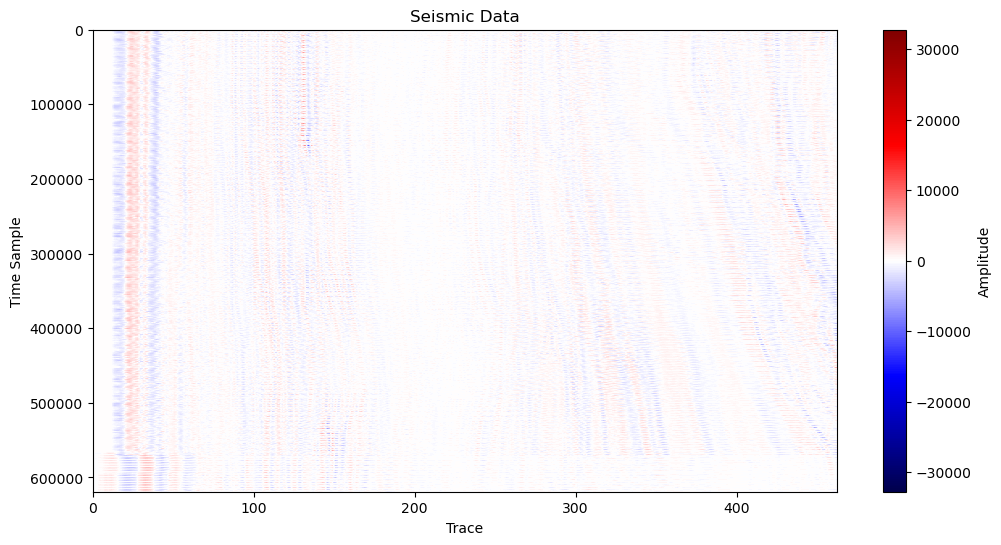

In [3]:
###########
# Test
###########    
file_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/F3_entire.segy'
seismic_data = read_segy_file(file_path)
#visualize_seismic_data(seismic_data)

max_length=find_max_trace_length(file_path)
data=preprocess_traces(file_path, max_length, padding_value=0)
visualize_seismic_data(data)


In [4]:
#TimeSeriesAugmentation(seq_len, warp_factor=0.1, num_knots=4)

data.shape

(619101, 462)

In [3]:
###############
# run model
###############
                
# Assuming `parsed_dataset` is your dataset loaded and parsed from TFRecords
# window_size = 50
# step_size = 25
# num_negative_pairs = 2  # Example: For each positive pair, generate 2 negative pairs


# # Determine input shape
# num_sequences, time_steps, num_features = data.shape
# input_shape = (time_steps, num_features)

# print(f"Input shape for the model should be: {input_shape}")


ValueError: not enough values to unpack (expected 3, got 2)

In [5]:
sequence_length = 128
step_size = 128  # To create non-overlapping sequences

# Segment the dataset
sequences = segment_into_sequences(data, sequence_length, step_size)
print(f"Generated sequences shape: {sequences.shape}")
# num_sequences, sequence_length, num_features

Generated sequences shape: (4836, 128, 462)


In [6]:
sequence_length = 128  # Example choice; you'll segment your data into sequences of this length
num_features = 462  # Based on your dataset's structure
feature_dim = 64  # Example choice for the size of the embedding vector

# Initialize the model
model = ContrastiveTimeSeriesModel(input_shape=(sequence_length, num_features), feature_dim=feature_dim)


In [7]:
model.compile(optimizer='adam', loss=model.contrastive_loss)

In [ ]:
num_positive_pairs = 1000  # Example quantity
num_negative_pairs = 1000  # Example quantity

model = ContrastiveTimeSeriesModel(input_shape=(128, 462), feature_dim=64)  # Example model initialization
pairs, labels = model.generate_pairs(data, num_positive_pairs, num_negative_pairs)

# Now `pairs` contains your generated positive and negative pairs,
# and `labels` contains the corresponding labels indicating whether a pair is positive or negative.

In [ ]:
generate_triplets(dataset, window_size=None, step_size=None, num_triplets=1000, augmentation_func=None)

In [21]:
# Generate the dataset of pairs
model = ContrastiveTimeSeriesModel(input_shape, feature_dim=64)
#pairs_dataset = model.generate_contrastive_pairs(parsed_dataset, window_size, step_size, num_negative_pairs, augmentation_func=model.simple_augmentation)


# Convert to tf.data.Dataset
#dataset = tf.data.Dataset.from_tensor_slices((pairs, labels))

# Assuming `train_dataset` is a tf.data.Dataset object that yields ([time_series_1, time_series_2], similarity_label) pairs
# model.train(train_dataset, epochs=10, batch_size=32)

TypeError: Exception encountered when calling TimeSeriesAugmentation.call().

[1mTimeSeriesAugmentation.generate_time_warp_curve() takes from 1 to 3 positional arguments but 4 were given[0m

Arguments received by TimeSeriesAugmentation.call():
  • args=('<KerasTensor shape=(None, 619101, 462), dtype=float32, sparse=None, name=keras_tensor_1>',)
  • kwargs={'training': 'True'}

In [3]:
##################
# Training routine
##################

###############
# reading data
###############    
file_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/F3_entire.segy'
seismic_data = read_segy_file(file_path)
#visualize_seismic_data(seismic_data)

#################
# preprocess data
#################
max_length=find_max_trace_length(file_path)
data=preprocess_traces(file_path, max_length, padding_value=0)
#visualize_seismic_data(data)

####################
# subsequence length
####################
sequence_length = 128
step_size = 128  # To create non-overlapping sequences

# Reshape the data into subsequences
subsequences = reshape_into_subsequences(data, sequence_length, step_size)
#sequences = segment_into_sequences(data, sequence_length, step_size)
print(f"Generated sequences shape: {subsequences.shape}")

################
# create patches
################
# Create patches from data
# patch_size = 500  # Length of each patch
# step = 500  # Step size between patches
# patches = create_patches(data, patch_size, step)

# Scale the subsequences
#subsequences_scaled, scaler = scale_subsequences(sequences)

#############
# Split data
#############

# Lets change this. We want to train on the whole dataset, then test on the whole dataset without augmented pairs.
# after we do this, 
X_train_val, X_test = train_test_split(subsequences, test_size=0.15, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.15, random_state=42)  

#############
# Scale data
#############
# scaler = StandardScaler()
# # X_train_scaled = scaler.fit_transform(X_train)
# # X_val_scaled = scaler.transform(X_val)
# # X_test_scaled = scaler.transform(X_test)
# train_patches = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# val_patches = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
# test_patches = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

#############################
# Generate pairs for training
#############################
# Assuming your model and generate_pairs function are defined
pairs_train, labels_train = generate_pairs(X_train, num_pairs=10000, positive_ratio=0.5)
pairs_val, labels_val = generate_pairs(X_val, num_pairs=2000, positive_ratio=0.5)
pairs_test, labels_test = generate_test_pairs(X_test, num_pairs=1000)

Generated sequences shape: (4836, 128, 462)


In [4]:
pairs_train.shape

(1000, 2, 128, 462)

In [4]:
#############
# Train model 
#############
#(assuming model is instance of ContrastiveTimeSeriesModel or similar)
#model.train_model(tf.data.Dataset.from_tensor_slices((pairs_train, labels_train)), epochs=50)

# Assuming 'data' is your loaded and preprocessed seismic dataset
#pairs, labels = generate_pairs(data, num_pairs=1000, positive_ratio=0.5)


# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((pairs_train, labels_train)).batch(32).prefetch(tf.data.AUTOTUNE)

# Initialize and train the model
input_shape = (128, 462)  # Example input shape
feature_dim = 64  # Embedding size
model = Contrastive1DCNNModel(input_shape=input_shape, feature_dim=feature_dim)

model.summary()  # To see the detailed architecture of the model



Model: "contrastive1dcnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       363,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,136 (1.39 MB)

 Trainable params: 363,136 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
#############
# Train model 
#############

model.train_model(train_dataset, epochs=10)

Epoch 1/10


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0000e+00
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0000e+00
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0000e+00


In [6]:
embeddings = model.get_embeddings(model, train_dataset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


In [21]:
embeddings_array = np.array(embeddings) 
#embeddings[1].shape
embeddings_array.shape

(2, 10000, 64)

In [27]:
#############
# Train model 
#############


# First Embedding (output_1): Represents the embedding of the first element of the input pair.
# Second Embedding (output_2): Represents the embedding of the second element of the input pair.

# Assuming embeddings is the array with shape (2, 10000, 64)
embeddings_1 = embeddings_array[0]  # First set of embeddings
embeddings_2 = embeddings_array[1]  # Second set of embeddings


# Cluster the embeddings using K-means
cluster_labels_kmeans_1 = model.cluster_embeddings(embeddings_1, method='kmeans', n_clusters=5)
cluster_labels_kmeans_2 = model.cluster_embeddings(embeddings_2, method='kmeans', n_clusters=5)


# Concatenate embeddings along the feature axis for joint clustering
combined_embeddings = np.concatenate((embeddings_1, embeddings_2), axis=1)  # shape becomes (10000, 128)
kmeans_combined = model.cluster_embeddings(combined_embeddings, method='kmeans', n_clusters=5)
# Or cluster the embeddings using hierarchical clustering
#cluster_labels_hierarchical = model.cluster_embeddings(embeddings, method='hierarchical', n_clusters=5, linkage_method='ward')

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# tsne = TSNE(n_components=2, random_state=42)
# test_embeddings_2d = tsne.fit_transform(cluster_labels_kmeans_1)

# plt.figure(figsize=(8, 6))
# plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], alpha=0.5)
# plt.title('t-SNE plot of Test Embeddings')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.show()

# Visualize using t-SNE
#model.visualize_clusters(embeddings, cluster_labels_kmeans, method='tsne')

# Visualize using UMAP
#model.visualize_clusters(embeddings, cluster_labels_hierarchical, method='umap')

In [29]:
cluster_labels_kmeans_1

# Assuming 'cluster_labels' is a flat array where each label corresponds to a segment of a trace
# and you know the 'time_steps' used to segment each trace.
time_steps = 619101  # total number of time steps you mentioned initially
traces = 462  # total number of traces

# Example reshaping if you clustered on individual segments or full traces directly
cluster_labels_reshaped = cluster_labels_kmeans_1.reshape((time_steps, traces))

ValueError: cannot reshape array of size 10000 into shape (619101,462)

In [9]:
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(32)  # Adjust batch size as needed
test_embeddings = model.get_embeddings(model, test_dataset)

NameError: name 'generate_test_pairs' is not defined

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
test_embeddings_2d = tsne.fit_transform(test_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], alpha=0.5)
plt.title('t-SNE plot of Test Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()